In [1]:
from functools import reduce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from scipy.stats.mstats import winsorize
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [22]:
"""
A deep learning neural network is used to classify terrorist attacks between 1970-2017 with 
unknown terrorist group affiliations. The model is trained on data provided by the Global 
Terrorism Database. The feature space includes categorical variables such as type of weapon used, 
victim type, suicide attacks, as well as numerical variables such as hostages taken, number of 
attackers, and number of fatalities. 

The model's two most frequent classifications are the Maoists and Taliban. In particular,
the results of the model suggest that the number of Maoist attacks is significantly underreported in 
the Global Terrorism Database (from 1630 reported attacks to model estimated of 4856 attacks).
The model also attributes an additional 2580 attacks to the Taliban.

Overall, the model seems to perform reasonably well with average precision and recall on the validation
set at approximately 76.3%. In other words, the model correctly classifies terrorist groups about 76.3%
of the time.

-Adam W

Data:
National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2018). 
Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd
"""

"\nA deep learning neural network is used to classify terrorist attacks between 1970-2017 with \nunknown terrorist group affiliations. The model is trained on data provided by the Global \nTerrorism Database. The feature space includes categorical variables such as type of weapon used, \nvictim type, suicide attacks, as well as numerical variables such as hostages taken, number of \nattackers, and number of fatalities. \n\nThe model's two most frequent classifications are the Maoists and Taliban. In particular,\nthe results of the model suggest that the number of Maoist attacks is significantly underreported in \nthe Global Terrorism Database (from 1630 reported attacks to model estimated of 4856 attacks).\nThe model also attributes an additional 2580 attacks to the Taliban.\n\nOverall, the model seems to perform reasonably well with average precision and recall on the validation\nset at approximately 76.3%. In other words, the model correctly classifies terrorist groups about 76.3%\no

In [3]:
# Reads the data and sets the index to 'eventid'. Missing values are encoded as -9,-99 
# according to database codebook.
df = pd.read_csv('Data/globalterrorismdb_0718dist.csv', header=0, na_values = ['-9','-99']).set_index('eventid')


C:\Development\Python\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# There are lots of missing data in the dataset and some variables only started 
# recording in 1997. Dropping all NaNs would result in significant loss of data, 
# so it maybe better to impute missing values and do some feature reduction.

# However, for variables with significant amount of NaNs, imputing/aggregation 
# may impose unrealistic assumptions about the distributions of the variables and 
# introduce bias. So variables with over 75% values NaN are excluded.
pct_na = df.isna().sum()/len(df)
ext_na = pct_na[~(pct_na > 0.75)]
df = df.loc[:,ext_na.index.values]

# For categorical variables, impute NaN with most common value (mode)
cat = df.select_dtypes('int64')
cat = cat.fillna(cat.mode())

# For numerical variables, impute NaN with the mean. Since the mean is sensitive 
# to large values, winsorize (1%) to limit the effect of extreme outliers
num = df.select_dtypes('float64')
num_no_nan = num.dropna()
num_winsor = winsorize(num_no_nan, limits = [0.01, 0.01])
num_mean = pd.DataFrame(num_winsor, index = num_no_nan.index, columns = num_no_nan.columns).mean()
num = num.fillna(num_mean)
num = pd.DataFrame(winsorize(num, limits = [0.01, 0.01]), index = num.index, columns = num.columns)



In [5]:
# The model will be trained on a mixed feature space with both categorical 
# and numerical variables. Normalizing the feature variances may be useful and 
# make the model more robust.

# Since categorical variables have varied scaling (1-k), they are split into k-vectors 
# with binary components. In other words, N categorical variables with ranges of 
# (k_1,...,k_N) are projected onto an N*k-dimensional space with unit norm.
cat_list = []
for col in cat:
    cat_list.append(pd.get_dummies(cat[col], prefix=str(col)))

cat_df = reduce(lambda x,y: pd.merge(x,y,on='eventid'), cat_list)

# Numerical variables are normalized to [0,1] so that they have similar scaling 
# with the categorical variables
num_scaled = (num - num.min(axis=0))/(num.max(axis=0) - num.min(axis=0))
num_df = pd.DataFrame(num_scaled, index = num.index, columns = num.columns)

df_clean = cat_df.merge(num_df, how='inner', on='eventid')

In [6]:
# Indices of attacks with unknown terrorist affiliations. These are the attacks 
# that will be classified and predicted by the model.
unknown = df[df['gname']=='Unknown'].index.values

# Processed dataset of unknown attacks to classify
X_to_classify = df_clean.loc[unknown,:]

# Processed dataset of known attacks to train/test the model
X_model = df_clean.drop(labels=unknown, axis=0)

In [7]:
# Converts terrorist group names into dummy variables
terrorist_groups = df.loc[:,'gname']
terrorist_groups_dummy = pd.get_dummies(terrorist_groups)

# Unknown terrorist groups (in dummy form) to classify
Y_to_classify = terrorist_groups_dummy.loc[unknown,:]

# Known terrorist groups (in dummy form) to train/test the model
Y_model = terrorist_groups_dummy.drop(labels=unknown, axis=0)

In [8]:
# Split data into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_model, Y_model, test_size=0.2, random_state=7)

In [9]:
# As the ultimate goal is to make predictions on terrorist group affiliations, 
# this is a classification problem. Thus, a multi-layer neural network could be 
# effective in capturing the complex and potential non-linear interactions 
# between the variables in the feature space. The activation function used is the 
# rectified linear unit, though the logistic sigmoid and hypolic tangent were tested 
# but do not demonstrate consistently better model performance.

# Dimension of feature space
n_features = X_model.shape[1]
n_groups = Y_model.shape[1]

# Sets up a sequential neural network
model = Sequential()

# Input Layer
model.add(Dense(n_features, activation='relu', input_shape=(n_features,)))

# Hidden Layers
model.add(Dense(150, activation='relu'))
model.add(Dense(100, activation='relu'))

# Output Layer. Activation function is softmax so it returns bounded values 
# (probabilities) for classification.
model.add(Dense(n_groups, activation='softmax'))

# Compilation
model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
)

# Stop the training process early if performance does not improve 
early_stop = EarlyStopping(patience=3)

# Fit the model
model.fit(X_train, Y_train,
          epochs=20,
          validation_split=0.2,
          callbacks=[early_stop,]
         )


Train on 63301 samples, validate on 15826 samples
Epoch 1/20
63301/63301 [==============================] - 60s 941us/step - loss: 2.5469 - acc: 0.5694 - val_loss: 1.8438 - val_acc: 0.6666
Epoch 2/20
63301/63301 [==============================] - 61s 967us/step - loss: 1.5013 - acc: 0.7028 - val_loss: 1.5244 - val_acc: 0.7184
Epoch 3/20
63301/63301 [==============================] - 60s 948us/step - loss: 1.2005 - acc: 0.7394 - val_loss: 1.3919 - val_acc: 0.7384
Epoch 4/20
63301/63301 [==============================] - 60s 945us/step - loss: 1.0234 - acc: 0.7638 - val_loss: 1.3383 - val_acc: 0.7500
Epoch 5/20
63301/63301 [==============================] - 62s 986us/step - loss: 0.8968 - acc: 0.7821 - val_loss: 1.3223 - val_acc: 0.7524
Epoch 6/20
63301/63301 [==============================] - 61s 969us/step - loss: 0.8008 - acc: 0.7989 - val_loss: 1.3131 - val_acc: 0.7560
Epoch 7/20
63301/63301 [==============================] - 60s 950us/step - loss: 0.7178 - acc: 0.8152 - val_loss: 1.

In [10]:
# Model predictions on test set
test_predictions = model.predict(X_test)

predict_df = pd.DataFrame(test_predictions, index=X_test.index)

In [11]:
# Model evaluation against test set

# Since output is probabilities, sets most likely group prediction to 1, rest 0
predict_grouped = predict_df.where(predict_df!=0).rank(1, ascending=False, method='dense').eq(1).astype(int)
predict_grouped.columns = Y_test.columns

# Returns classification metrics to evaluate the model
report = classification_report(Y_test, predict_grouped, target_names=Y_test.columns, output_dict=True)

model_performance = report['micro avg'], report['weighted avg']

model_perf_summary = pd.DataFrame({
                    'Precision': [model_performance[0]['precision'], model_performance[1]['precision']],
                    'Recall': [model_performance[0]['recall'], model_performance[1]['recall']],
                    'F1-Score': [model_performance[0]['f1-score'], model_performance[1]['f1-score']]
}, index = ['MicroAverage','WeightedAverage']
)

print(model_perf_summary)

                 Precision   Recall  F1-Score
MicroAverage      0.763270  0.76327  0.763270
WeightedAverage   0.741179  0.76327  0.742737


C:\Development\Python\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Development\Python\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Development\Python\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Development\Python\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Devel

In [12]:
# The model seems to perform fairly well on the test set. The final steps are to
# make predictions for the unknown attacks.

new_predictions = model.predict(X_to_classify)

new_df = pd.DataFrame(new_predictions, index=X_to_classify.index)

new_predict_grouped = new_df.where(new_df!=0).rank(1, ascending=False, method='dense').eq(1).astype(int)
new_predict_grouped.columns = Y_to_classify.columns

In [15]:
# Predictions for the unknown terrorist group affiliations

# Makes predictions for terrorist group affiliation based on maximum probability
new_groups = new_df.idxmax(axis=1)

reconstruct_group = []
for row in new_groups:
    reconstruct_group.append(terrorist_groups_dummy.columns[row])
    
model_predictions = pd.DataFrame(reconstruct_group, index=new_groups.index)
model_predictions.columns = ['Predicted Terrorist Group Affiliation']

model_predictions.sample(20)

,Predicted Terrorist Group Affiliation
eventid,
199601260008,Muslim Militants
199711110010,November 17 Revolutionary Organization (N17RO)
201309140037,Tribesmen
197804180001,23rd of September Communist League
200108290020,National Liberation Army (NLA) (Macedonia)
199109070007,Muslim Separatists
198708020005,Terrorists
201302040029,Muslim extremists
201203310025,Tribesmen


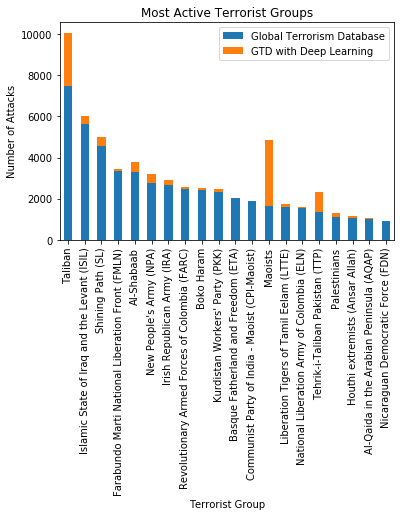

In [14]:
# Visualization of the results

# Sum of attack counts for original dataset
original_sums = Y_model.sum(axis=0)

# Sum of attack counts for ML classified dataset 
full_df = pd.concat([Y_model, new_predict_grouped], axis=0, join='outer')
full_sums = full_df.sum(axis=0)

# Plot of 20 most active terrorist groups
most_attacks = original_sums.nlargest(20)

most_attacks_model = full_sums[most_attacks.index]
model_diff = most_attacks_model - most_attacks

attacks_df = pd.concat([most_attacks,model_diff], axis=1)
attacks_df.columns = ['Global Terrorism Database', 'GTD with Deep Learning']
attacks_df.plot.bar(stacked=True)

plt.title('Most Active Terrorist Groups')
plt.ylabel('Number of Attacks')
plt.xlabel('Terrorist Group')
plt.show()

In [16]:
# Most frequent classifications made by model
model_diff.nlargest(5)

Maoists                            3226
Taliban                            2580
Tehrik-i-Taliban Pakistan (TTP)     967
Al-Shabaab                          482
New People's Army (NPA)             446
dtype: int64